# Review Post Attributes Models

This notebook builds a range of machine learning models to predict a user's sentiment based upon various review post attributes.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing and feature engineering
* Section 3 - Classifier Models and Summary



Datasets needed to run this notebook:

* models1.csv


 Review Post Features used for modelling:
 
* User Past Contributions
* Town where the establishment is located
* Category - accommodation, food or attraction
* Date of review - when review is posted
* Location of user - overseas, local or rest of UK
* Outlet type - e.g. (hotel, B&B) or (restaurant,fast-food outlet)
* Cuisine type - e.g. British, Italian, Seafood etc


# Section 1: Import Libraries and Dataset

In [1]:
#!pip install -U imbalanced-learn

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFECV,VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,fbeta_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [68]:
# Read in dataset from MScExploratory Data Analysis Part One
df = pd.read_csv("models1.csv",index_col = 0)
df.drop(columns = ["Title","Review","Name"],axis =1,inplace = True)

In [69]:
df.head(2)

,Category,Town,Type,Contributions,Rating,Date,LocCode,Cuisine
0,Accommodation,Arundel,Hotel,1278,4,4.0,2.0,0
1,Accommodation,Arundel,B&B/Inn,1163,5,4.0,2.0,0


In [70]:
df.shape

(10325, 8)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10325 entries, 0 to 10324
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Category       10325 non-null  object 
 1   Town           10325 non-null  object 
 2   Type           10325 non-null  object 
 3   Contributions  10325 non-null  int64  
 4   Rating         10325 non-null  int64  
 5   Date           10325 non-null  float64
 6   LocCode        10325 non-null  float64
 7   Cuisine        10325 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 726.0+ KB


# Section 2: Preprocessing and Feature Engineering

## Combine types for simplification

In [72]:
# Get cuisine types
df["Cuisine"].value_counts()

0                3654
British          3638
Other            1109
Italian/Pizza     573
Seafood           471
Indian            426
Chinese/Thai      248
American          204
International       2
Name: Cuisine, dtype: int64

In [73]:
# Strip whitespace from Type column
df.Type = df.Type.str.strip()

In [74]:
# Combine categories to simplify model
df["Cuisine"] = df["Cuisine"].replace(["Chinese/Thai","Indian"],"Asian/Oriental")
df["Cuisine"] = df["Cuisine"].replace(["Seafood","American","n/a"],["British","Other","Not Specified"])
df["Type"] = df["Type"].replace(["Steakhouse/Diner","Gastropub"],["Restaurant","Pub/Bar"])

In [75]:
df.head(2)

,Category,Town,Type,Contributions,Rating,Date,LocCode,Cuisine
0,Accommodation,Arundel,Hotel,1278,4,4.0,2.0,0
1,Accommodation,Arundel,B&B/Inn,1163,5,4.0,2.0,0


In [86]:
df.columns

Index(['Category', 'Town', 'Type', 'Contributions', 'Rating', 'Date',
       'LocCode', 'Cuisine'],
      dtype='object')

## Create dummies

In [87]:
def change_funct(df):   
    
    # Set Date and LocCode to category
    df["Date"] = df["Date"].astype('category')
    df["LocCode"] = df["LocCode"].astype('category')
        
    # Rescale contributions column (standard scaler produces negative results so minmaxscaler is used)
    scaler = MinMaxScaler()
    df["Contributions"] = scaler.fit_transform(df[["Contributions"]])
    
    # Create dummies
    non_dummy_cols = df[["Contributions","Rating"]]
    dummy_cols = list(set(df.columns) - set(non_dummy_cols))
    df = pd.get_dummies(df, columns=dummy_cols, drop_first = True)
    return df

In [88]:
df_changed = change_funct(df)

## Set ratings to binary

In [92]:
# Create new column for Score and set binary values for ratings
df_changed["Score"] = df_changed["Rating"]
df_changed = df_changed[df_changed["Rating"] != 3]
df_changed.Score.replace([1,2], 1, inplace = True)
df_changed.Score.replace([4,5], 0, inplace = True)
df_changed.drop(columns = ["Rating"],axis = 1, inplace = True)

## Look at relationships between the variables

[]

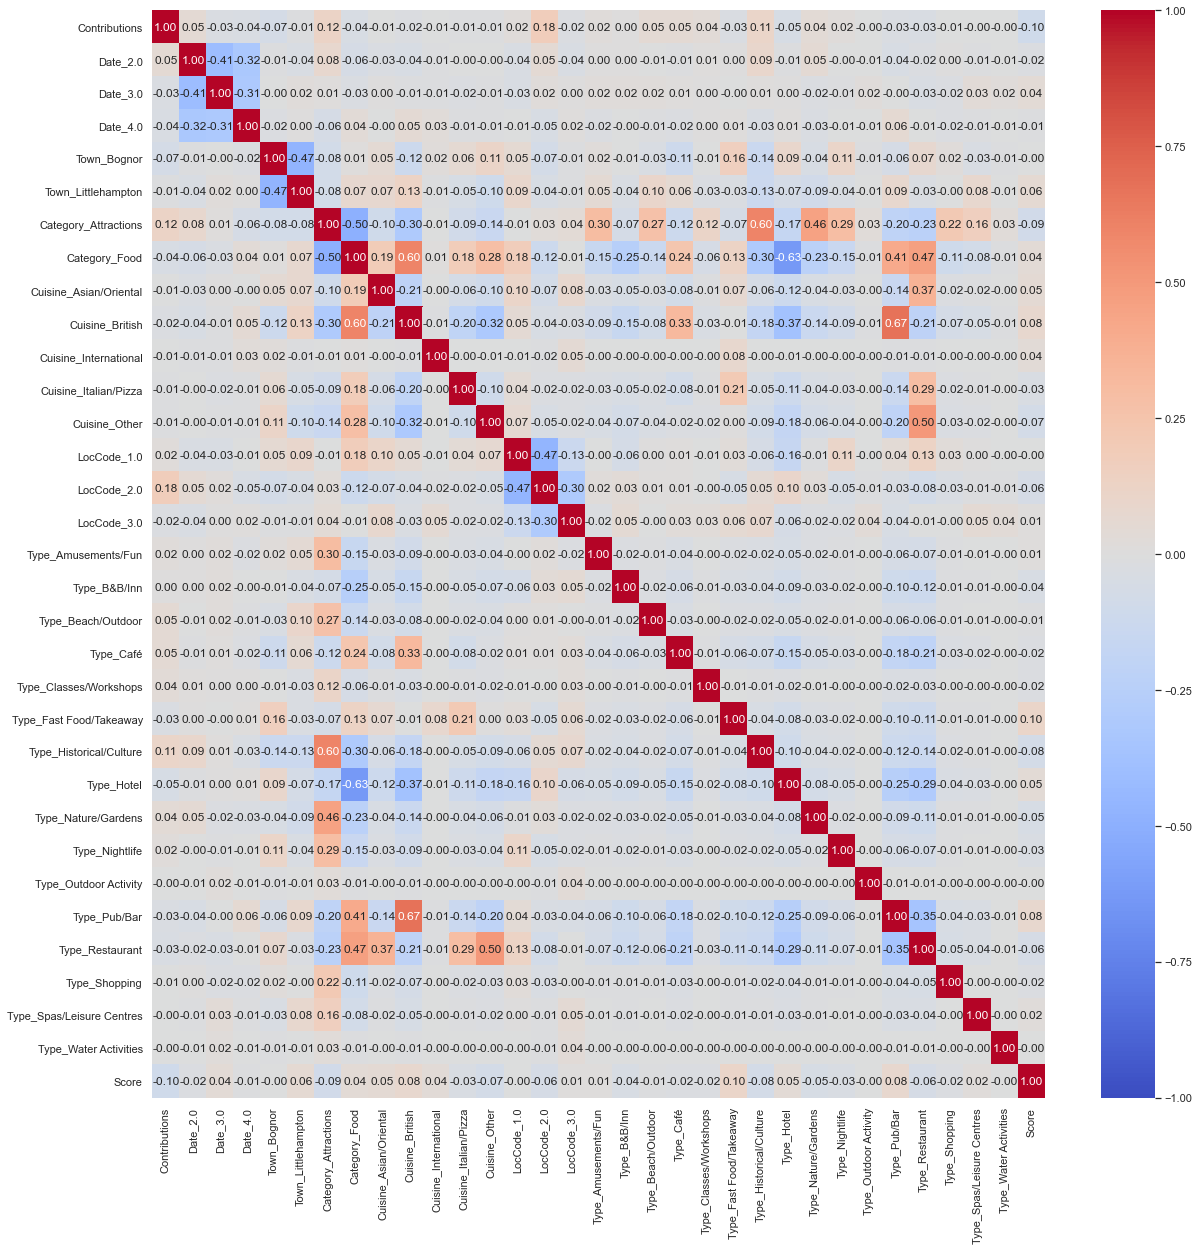

In [102]:
# Look at a heatmap to see where there might be relationships
plt.figure(figsize=(20,20))
sns.heatmap(df_changed.corr(), annot = True, vmin=-1, cmap='coolwarm',fmt=".2f")
plt.plot()

## Sampling

In [103]:
# Function to get balanced sample based on ratings for each dataframe
def sampling(df,sample_size):
    sampled_good = df[df["Score"] == 0].sample(sample_size)
    sampled_bad = df[df["Score"] == 1]
    new_df = sampled_good.append(sampled_bad)
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [104]:
df_balanced = sampling(df_changed,df_changed.Score.value_counts()[1])
df_balanced["Score"].value_counts()

0    1301
1    1301
Name: Score, dtype: int64

## Train, test, split

In [113]:
X = df_balanced.drop(columns = "Score",axis = 1)
y = df_balanced["Score"]

In [114]:
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, random_state=1)     
    return X_train,y_train,X_val,y_val,X_test,y_test

In [115]:
# Run function
X_train,y_train,X_val,y_val,X_test,y_test = splitting(X,y)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(2081, 32) (2081,) (261, 32) (261,) (260, 32) (260,)


In [116]:
# Values of Scores - check balanced
y_train.value_counts()

0    1041
1    1040
Name: Score, dtype: int64

## Feature selection

### a) Select K-best Features - Categorical Variables Only

In [121]:
X_train_cat.shape

(2081, 31)

Feature 0: 0.915187
Feature 1: 5.900218
Feature 2: 0.026470
Feature 3: 0.409192
Feature 4: 13.963973
Feature 5: 42.937699
Feature 6: 3.069913
Feature 7: 8.134638
Feature 8: 13.116689
Feature 9: 2.001923
Feature 10: 5.410922
Feature 11: 16.759773
Feature 12: 0.247666
Feature 13: 8.406055
Feature 14: 0.203576
Feature 15: 1.004811
Feature 16: 8.944013
Feature 17: 0.526533
Feature 18: 4.241211
Feature 19: 2.997118
Feature 20: 28.562943
Feature 21: 34.278807
Feature 22: 6.095045
Feature 23: 21.325778
Feature 24: 7.988473
Feature 25: nan
Feature 26: 16.884531
Feature 27: 6.786565
Feature 28: 0.332373
Feature 29: 0.401925
Feature 30: nan


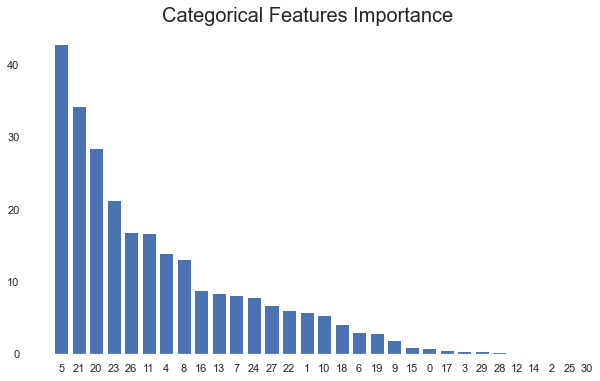

In [122]:
# Function to find the categorical features with the highest Chi squared value
X_train_cat = X_train.drop(columns = ["Contributions"])
chi2_selector = SelectKBest(chi2, k=10)
best = chi2_selector.fit(X_train_cat,y_train)
X_best = best.scores_
best_df = pd.DataFrame(X_best)
best_df = best_df.sort_values(by = 0,ascending = False)
best_df.columns = ["Scores"]
for i in range(len(best.scores_)):
    print('Feature %d: %f' % (i, best.scores_[i]))

fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
plt.bar([i for i in range(len(best_df))], best_df.Scores)
plt.title("Categorical Features Importance", size = 20)
plt.xticks(range(0,31),best_df.index)
plt.show()

### b) Recursive Feature Elimination

In [123]:
# Recursive Feature Elimination using cross validation to eliminate features that don't contribute to accuracy
def recurse(model,X,y):
    rfecv = RFECV(estimator = model, step = 1, scoring = "accuracy")
    rfecv.fit(X,y)
    rfecv.transform(X)
    return rfecv

In [124]:
# Set up recursive elimnatinon model
result = recurse(LogisticRegression(random_state = 0),X_train,y_train)

In [125]:
# Print number of important features
result.n_features_

24

In [126]:
# Grid Scores
result.grid_scores_

array([0.57713521, 0.5819383 , 0.58674483, 0.59395176, 0.59299368,
       0.60067677, 0.616541  , 0.62134062, 0.62662908, 0.62614947,
       0.62182139, 0.62037908, 0.62230216, 0.62230216, 0.624706  ,
       0.63143216, 0.6338314 , 0.63286871, 0.6251787 , 0.63335178,
       0.63191063, 0.63094909, 0.63287216, 0.63527716, 0.63335293,
       0.6338337 , 0.63190832, 0.63190717, 0.63479178, 0.63334947,
       0.63334947, 0.63334947])

In [127]:
# Rank the features
result.ranking_

array([1, 2, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 8, 6, 1, 7, 1, 9])

In [128]:
# Find those features the model suggests as significant
result.support_

array([ True, False,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True, False])

Suggests that most features are relevant so leave in the model as it only affects the time taken to run the model. 

# Section 3: Classifier Models

## a) Fitting and Training Models

There is an imbalanced number of examples of each class so the dataset is split into train and test sets to maintain the same proportions of examples for each class as found in the original dataset using stratifified K-fold.

In [129]:
# Function to train classifier models
def train_accuracy(model):
    rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    scores = cross_val_score(model, X_train, y_train, cv = rkf, scoring = 'accuracy',n_jobs =-1)
    return scores.mean()

Measure baseline performance, using a dummy classifier model that chooses the majority class each time. Different classifiers can be measured against this benchmark and should outperform it.

### Dummy Classifer and Baseline ML Models

In [130]:
# Set models with defaut parameters
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True, kernel = 'rbf')

In [131]:
# Train models
dum_train = train_accuracy(dummy_model)
nb_train = train_accuracy(nb)
log_train = train_accuracy(lr)
rf_train = train_accuracy(rf)
svm_train = train_accuracy(svm)

In [132]:
train_summary = pd.DataFrame({"Dummy":[dum_train],"Naive Bayes":[nb_train],"LogReg":[log_train],"Random Forest": [rf_train],
                              "SVM":[svm_train]})
train_summary

,Dummy,Naive Bayes,LogReg,Random Forest,SVM
0,0.506006,0.608675,0.633838,0.587537,0.615251


The models outperformed the Dummy Classifier which is simply based on a uniform random selection

## b) Predicting With Each Model

Definitions:

A positive result (category of interest) is a BAD REVIEW which is this case is the minority class. 

A negative result is a GOOD REVIEW which is the majority class.

* TP = True Positive. Negative/bad reviews the model predicts as negative.
* TN = True Negative. Positive/good reviews the model predicts as positive.
* FP = False Positive. Positive/good reviews the model predicts as negative.
* FN = False Negative. Negative/bad reviews the model predicts as postitive.

In [133]:
# Create function to run diagnostic reports and graphs

def run_mod(model,X,y):
    
    # Fit model on training set and predict on test set
    model_name = str(model)
    model.fit(X,y)
    y_pred = model.predict(X_val)
        
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, val_scores = learning_curve(model,X,y, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    val_mean = np.mean(val_scores, axis = 1)
    val_std = np.mean(val_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Balanced_acc":balanced_accuracy,
                                    "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
     
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    

### Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.69      0.49      0.57       130
           1       0.61      0.78      0.68       131

    accuracy                           0.64       261
   macro avg       0.65      0.64      0.63       261
weighted avg       0.65      0.64      0.63       261



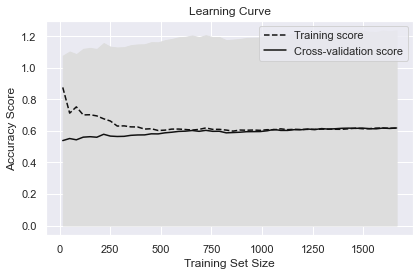

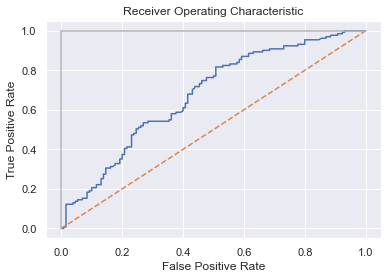

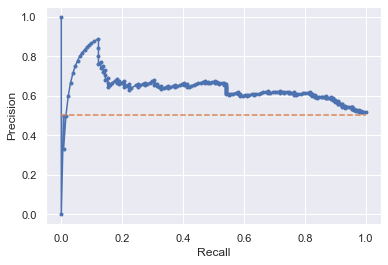

Best F1 score: 0.6822742474916388 Best threshold value: 0.1


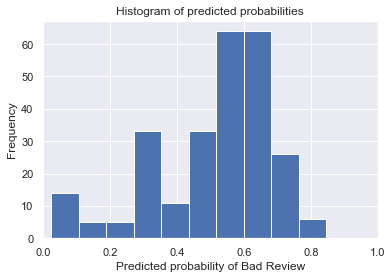

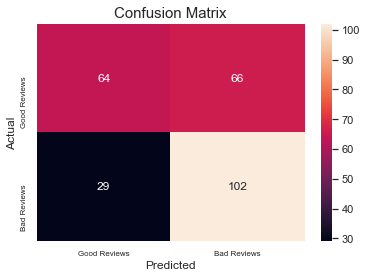

In [134]:
run_mod(nb,X_train,y_train)

In [135]:
nb_base = run_mod.results
nb_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.636015,0.635467,0.607143,0.778626,0.682274,0.736994,0.675279,0.638812


### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       130
           1       0.61      0.68      0.64       131

    accuracy                           0.62       261
   macro avg       0.63      0.62      0.62       261
weighted avg       0.63      0.62      0.62       261



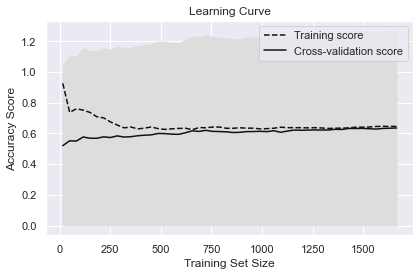

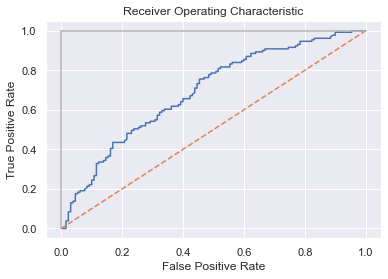

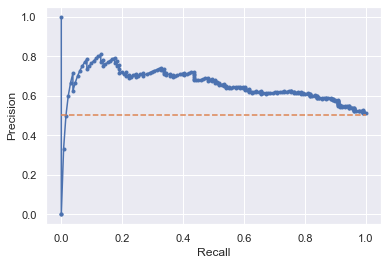

Best F1 score: 0.644927536231884 Best threshold value: 0.1


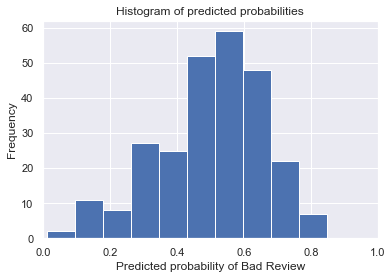

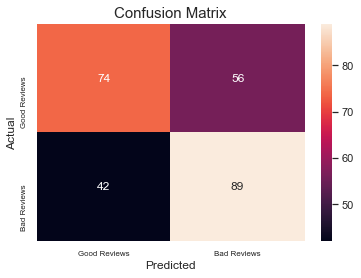

In [136]:
run_mod(lr,X_train,y_train)

In [137]:
lr_base = run_mod.results
lr_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.624521,0.62431,0.613793,0.679389,0.644928,0.665172,0.690722,0.654603


### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       130
           1       0.57      0.58      0.58       131

    accuracy                           0.57       261
   macro avg       0.57      0.57      0.57       261
weighted avg       0.57      0.57      0.57       261



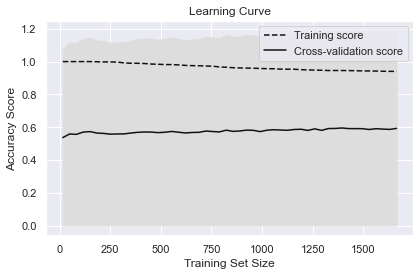

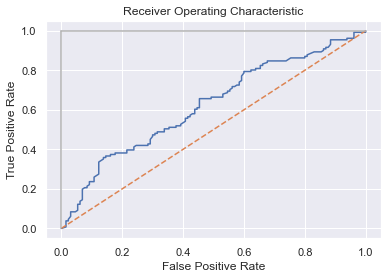

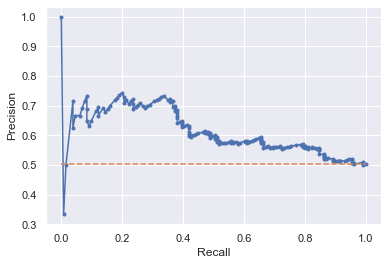

Best F1 score: 0.5757575757575758 Best threshold value: 0.1


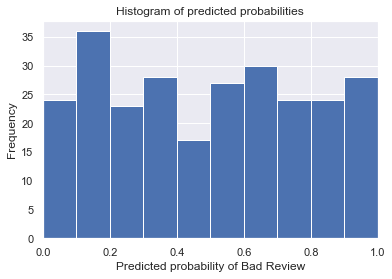

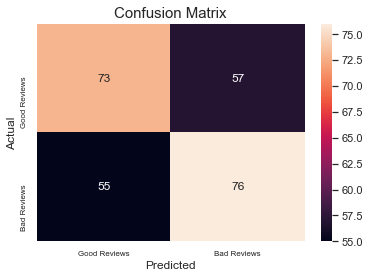

In [138]:
run_mod(rf,X_train,y_train)

In [139]:
rf_base = run_mod.results
rf_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.570881,0.570846,0.571429,0.580153,0.575758,0.578387,0.623371,0.611943


### Support Vector Machine Classifier 

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       130
           1       0.63      0.69      0.66       131

    accuracy                           0.64       261
   macro avg       0.65      0.64      0.64       261
weighted avg       0.64      0.64      0.64       261



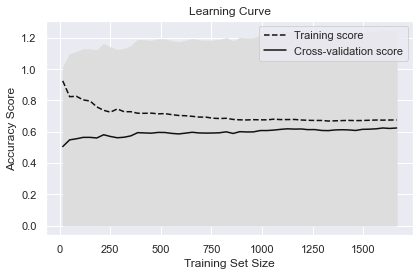

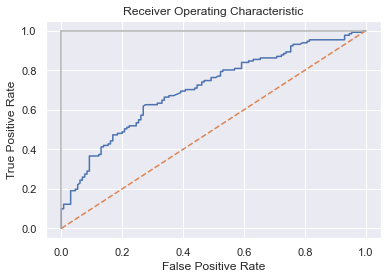

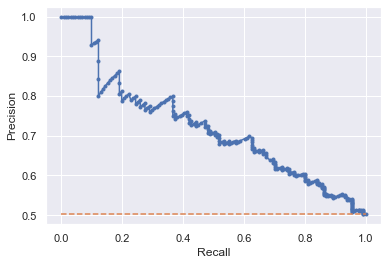

Best F1 score: 0.6618181818181817 Best threshold value: 0.1


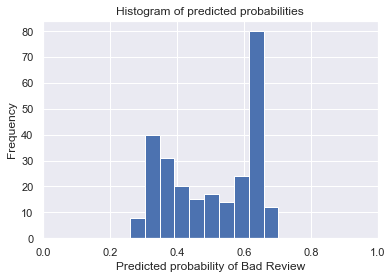

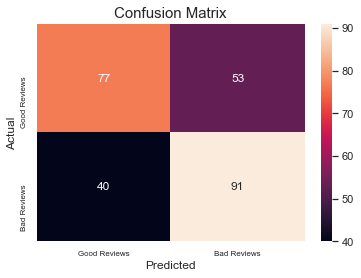

In [140]:
run_mod(svm,X_train,y_train)

In [141]:
svm_base = run_mod.results
svm_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.643678,0.643482,0.631944,0.694656,0.661818,0.681138,0.705696,0.720355


In [142]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector"]

training_summary = pd.concat([nb_base,lr_base,rf_base,svm_base])
training_summary.set_index([models],inplace = True)
training_summary

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.636015,0.635467,0.607143,0.778626,0.682274,0.736994,0.675279,0.638812
Logistic Regression,0.624521,0.624310,0.613793,0.679389,0.644928,0.665172,0.690722,0.654603
Random Forest,0.570881,0.570846,0.571429,0.580153,0.575758,0.578387,0.623371,0.611943
Support Vector,0.643678,0.643482,0.631944,0.694656,0.661818,0.681138,0.705696,0.720355
